In [1]:
###############################################################
# RFM ile Müşteri Segmentasyonu Örnek Proje - Erdem Bostancı (Customer Segmentation with RFM)
###############################################################

# 1. İş Problemi (Business Problem)
# 2. Veriyi Anlama (Data Understanding)
# 3. Veri Hazırlama (Data Preparation)
# 4. RFM Metriklerinin Hesaplanması (Calculating RFM Metrics)
# 5. RFM Skorlarının Hesaplanması (Calculating RFM Scores)
# 6. RFM Segmentlerinin Oluşturulması ve Analiz Edilmesi (Creating & Analysing RFM Segments)
# 7. Tüm Sürecin Fonksiyonlaştırılması

###############################################################
# 1. İş Problemi (Business Problem)
###############################################################

# Bir e-ticaret şirketi müşterilerini segmentlere ayırıp bu segmentlere göre
# pazarlama stratejileri belirlemek istiyor.

# Veri Seti Hikayesi
# https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

# Online Retail II isimli veri seti İngiltere merkezli online bir satış mağazasının
# 01/12/2009 - 09/12/2011 tarihleri arasındaki satışlarını içeriyor.

# Değişkenler
#
# InvoiceNo: Fatura numarası. Her işleme yani faturaya ait eşsiz numara. C ile başlıyorsa iptal edilen işlem.
# StockCode: Ürün kodu. Her bir ürün için eşsiz numara.
# Description: Ürün ismi
# Quantity: Ürün adedi. Faturalardaki ürünlerden kaçar tane satıldığını ifade etmektedir.
# InvoiceDate: Fatura tarihi ve zamanı.
# UnitPrice: Ürün fiyatı (Sterlin cinsinden)
# CustomerID: Eşsiz müşteri numarası
# Country: Ülke ismi. Müşterinin yaşadığı ülke.



###############################################################
# 2. Veriyi Anlama ve Veri Hazırlama
###############################################################

In [2]:
import datetime as dt
import pandas as pd

In [3]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
df_= pd.read_excel("/content/online_retail_II.xlsx", sheet_name="Year 2009-2010")
df = df_.copy()

In [5]:
df.head() #Verimiz yüklenmiş mi inceleyelim:

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.950,13085.000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,13085.000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750,13085.000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.100,13085.000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.250,13085.000,United Kingdom


In [6]:
df.isnull().sum() #toplam eksik satırlar

,0
Invoice,0
StockCode,0
Description,2928
Quantity,0
InvoiceDate,0
Price,0
Customer ID,107927
Country,0


In [7]:
df.shape #veri sayısı

(525461, 8)

In [8]:
df["Description"].nunique() #ürünler faturada kaç kere geçti? (Quantity dahil değil)

4681

In [9]:
df['Description'].value_counts() #Bu da hangi ürünlerin geçtiğiyle beraber (quantity hariç)

,count
Description,
WHITE HANGING HEART T-LIGHT HOLDER,3549
REGENCY CAKESTAND 3 TIER,2212
STRAWBERRY CERAMIC TRINKET BOX,1843
PACK OF 72 RETRO SPOT CAKE CASES,1466
ASSORTED COLOUR BIRD ORNAMENT,1457
...,...
stock credited from royal yacht inc,1
VINTAGE METAL CAKE STAND CREAM,1
BLUE BAROQUE FLOCK CANDLE HOLDER,1


In [10]:
df.dropna(inplace=True) #eksik satırları sildik
df.isnull().sum() #eksik satırımız yok

,0
Invoice,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
Price,0
Customer ID,0
Country,0


In [11]:
df.describe().T #price-quantity minimum'da eksi ve sıfır değer olması, ft.'lerin iade olduğunu gösteriyor.

,count,mean,min,25%,50%,75%,max,std
Quantity,417534.000,12.759,-9360.000,2.000,4.000,12.000,19152.000,101.220
InvoiceDate,417534,2010-07-01 01:12:19.787609856,2009-12-01 07:45:00,2010-03-26 11:26:00,2010-07-08 19:12:00,2010-10-14 14:08:00,2010-12-09 20:01:00,NaN
Price,417534.000,3.888,0.000,1.250,1.950,3.750,25111.090,71.132
Customer ID,417534.000,15360.645,12346.000,13983.000,15311.000,16799.000,18287.000,1680.811


In [12]:
df = df[~df['Invoice'].str.contains('C',na=False)] #İade fatura numaraları C ile başlıyor. Bunları kaldırdık.

In [13]:
df.shape

(407695, 8)

In [14]:
df['Ürün_Toplam_Fiyatı'] = df['Quantity'] * df['Price'] #Bir Ft. içinde alınan toplam ürün fiyatı değişkeni oluşturduk.

<ipython-input-14-e415ede2780d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ürün_Toplam_Fiyatı'] = df['Quantity'] * df['Price'] #Bir Ft. içinde alınan toplam ürün fiyatı değişkeni oluşturduk.


In [15]:
df.groupby('Invoice').agg({'Ürün_Toplam_Fiyatı':sum}) #İncelemek adına her ft. üzerinde yapılan toplam harcamayı görelim.
# Hem de 'Monetary' değerini önceden hesaplamış oluruz.

<ipython-input-15-6207feeb0fab>:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df.groupby('Invoice').agg({'Ürün_Toplam_Fiyatı':sum})


,Ürün_Toplam_Fiyatı
Invoice,
489434,505.300
489435,145.800
489436,630.330
489437,310.750
489438,2286.240
...,...
538167,298.950
538168,318.700
538169,93.450


---

## RFM Metriklerinin Hesaplanması

---





In [16]:
#Recency, Frequency, Monetary Hesaplanması:
today_Date=dt.datetime(2010,12,11)

In [17]:
df.groupby('Invoice').agg({'InvoiceDate':'max'}).head()

,InvoiceDate
Invoice,
489434,2009-12-01 07:45:00
489435,2009-12-01 07:46:00
489436,2009-12-01 09:06:00
489437,2009-12-01 09:08:00
489438,2009-12-01 09:24:00


In [18]:
rfm_ = df.groupby('Customer ID').agg({'InvoiceDate':(lambda InvoiceDate: (today_Date - InvoiceDate.max()).days),
                                      'Invoice': lambda Invoice: Invoice.nunique(),
                                      'Ürün_Toplam_Fiyatı':lambda Ürün_Toplam_Fiyatı:Ürün_Toplam_Fiyatı.sum()})
#RFM metriklerini hesaplamak için lambda fonksiyonuyla hızlı bir formül verdik ve yeni sütun olarak yerleştirdik.

In [19]:
rfm_.head()

,InvoiceDate,Invoice,Ürün_Toplam_Fiyatı
Customer ID,,,
12346.000,165,11,372.860
12347.000,3,2,1323.320
12348.000,74,1,222.160
12349.000,43,3,2671.140
12351.000,11,1,300.930


In [20]:
rfm_.columns = ['Recency','Frequency','Monetary'] #Hesaplama yaptığımız sütunların ismini değiştirdik.

In [27]:
rfm_ = rfm_[rfm_['Monetary']>0] #Monetary değerinde iade ft.lerden kalan '0' değerler vardı minimumda... Bunları kaldırdık.

In [28]:
rfm_.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,4312.000,91.173,96.861,1.000,18.000,53.000,136.000,374.000
Frequency,4312.000,4.456,8.170,1.000,1.000,2.000,5.000,205.000
Monetary,4312.000,2048.238,8914.481,2.950,307.988,706.020,1723.142,349164.350




---

RFM SKORLARININ HESAPLANMASI


---

In [30]:
rfm_['Recency_Score']=pd.qcut(rfm_['Recency'],5,labels=[5,4,3,2,1])
rfm_['Frequency_Score']=pd.qcut(rfm_['Frequency'].rank(method='first'),5,labels=[1,2,3,4,5])
rfm_['Monetary_Score']=pd.qcut(rfm_['Monetary'],5,labels=[1,2,3,4,5])
#pd.qcut fonksiyonu ile eşit aralıklara bölerek 1-5 arasında puanlamaya tabi tuttuk.
#Frequency skorunda ft. ID'ye göre sıralama yaptığından belirli eşit parçalara bölemedi bu yüzden .rank() objesini kullandık.

In [31]:
rfm_.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score
Customer ID,,,,,,
12346.000,165,11,372.860,2,5,2
12347.000,3,2,1323.320,5,2,4
12348.000,74,1,222.160,2,1,1
12349.000,43,3,2671.140,3,3,5
12351.000,11,1,300.930,5,1,2


In [34]:
rfm_['rfm_score'] = (
    rfm_['Recency_Score'].astype(str) +
    rfm_['Frequency_Score'].astype(str) +
    rfm_['Monetary_Score'].astype(str))
#Her bir müşteri ID üzerinden tam bir puanlama yapmak için hepsini string bilgi yapıp topladık.

In [35]:
rfm_.head() #En sağda tam RFM skorumuz görünüyor.

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,rfm_score
Customer ID,,,,,,,
12346.000,165,11,372.860,2,5,2,252
12347.000,3,2,1323.320,5,2,4,524
12348.000,74,1,222.160,2,1,1,211
12349.000,43,3,2671.140,3,3,5,335
12351.000,11,1,300.930,5,1,2,512


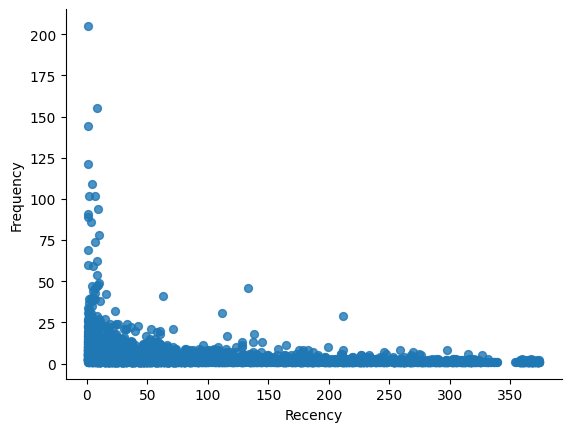

In [40]:
# Recency ve Frequency

from matplotlib import pyplot as plt
rfm_.plot(kind='scatter', x='Recency', y='Frequency', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)



---


RFM SKORLARINA GÖRE MÜŞTERİLERİ ID'LERİNİN SEGMENTE EDİLMESİ


---



In [52]:
seg_map = {
    r'[1-2][1-2][1-5]': 'uykuda',
    r'[1-2][3-4][1-5]': 'riskli',
    r'[1-2]5[1-5]': 'kaybedilmemeli',
    r'3[1-2][1-5]': 'uyumak_uzere',
    r'33[1-5]': 'dikkat',
    r'[3-4][4-5][1-5]': 'sadik',
    r'41[1-5]': 'umit_verici',
    r'51[1-5]': 'yeni',
    r'[4-5][2-3][1-5]': 'potansiyel_sadik',
    r'5[4-5][1-5]': 'sampiyon'
}
#Segmente edilirken Monetary Score genelde konulmaz. Ancak yine de incelenmesi açısından sütuna ekledim.

In [53]:
rfm_['segment'] = rfm_['rfm_score'].replace(seg_map, regex=True)
rfm_.head()

,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,rfm_score,segment
Customer ID,,,,,,,,
12346.000,165,11,372.860,2,5,2,252,kaybedilmemeli
12347.000,3,2,1323.320,5,2,4,524,potansiyel_sadik
12348.000,74,1,222.160,2,1,1,211,uykuda
12349.000,43,3,2671.140,3,3,5,335,dikkat
12351.000,11,1,300.930,5,1,2,512,yeni


In [62]:
rfm_[['segment','Recency','Frequency','Monetary']].groupby('segment').agg(['mean','count'])

Recency       Frequency       Monetary      
                    mean count      mean count     mean count
segment                                                      
dikkat            53.266   207     2.449   207 1060.357   207
kaybedilmemeli   124.117    77     9.117    77 4099.450    77
potansiyel_sadik  18.793   517     2.017   517  729.511   517
riskli           152.159   611     3.074   611 1188.878   611
sadik             36.287   742     6.830   742 2746.067   742
sampiyon           7.119   663    12.554   663 6852.264   663
umit_verici       25.747    87     1.000    87  367.087    87
uykuda           213.886  1015     1.126  1015  403.978  1015
uyumak_uzere      53.819   343     1.201   343  441.320   343
yeni               8.580    50     1.000    50  386.199    50



---


## FONKSIYONLASTIRMA


---




In [63]:
def create_rfm(dataframe, csv=False):

    # Veri hazırlama
    dataframe["TotalPrice"] = dataframe["Quantity"] * dataframe["Price"]
    dataframe.dropna(inplace=True)
    dataframe = dataframe[~dataframe["Invoice"].str.contains("C", na=False)]

    # RFM metrik hesaplama
    today_date = dt.datetime(2011, 12, 11)
    rfm = dataframe.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days,
                                                'Invoice': lambda num: num.nunique(),
                                                "TotalPrice": lambda price: price.sum()})
    rfm.columns = ['recency', 'frequency', "monetary"]
    rfm = rfm[(rfm['monetary'] > 0)]

    # RFM skor hesaplaması
    rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
    rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
    rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])


    #
    rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                        rfm['frequency_score'].astype(str))


    # segmentleri  isimlendirme
    seg_map = {
        r'[1-2][1-2]': 'hibernating',
        r'[1-2][3-4]': 'at_risk',
        r'[1-2]5': 'cant_loose',
        r'3[1-2]': 'about_to_sleep',
        r'33': 'need_attention',
        r'[3-4][4-5]': 'loyal_customers',
        r'41': 'promising',
        r'51': 'new_customers',
        r'[4-5][2-3]': 'potential_loyalists',
        r'5[4-5]': 'champions'
    }

    rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
    rfm = rfm[["recency", "frequency", "monetary", "segment"]]
    rfm.index = rfm.index.astype(int)

    if csv:
        rfm.to_csv("rfm.csv")

    return rfm


df = df_.copy()

rfm_new = create_rfm(df, csv=True)